In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 数据加载
transform = transforms.Compose([
    transforms.ToTensor(),  # 转为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 833476.48it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 385563.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1240672.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3712829.62it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [4]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=400, output_dim=784):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon

In [5]:
# VAE
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [6]:
# 损失函数
def vae_loss(x_recon, x, mu, logvar):
    # BCE重建损失
    bce = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    # KL散度
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

In [8]:
# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# 初始化模型和优化器
latent_dim = 2
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [17]:
# 训练循环
def train_epoch(model, loader, optimizer, device=device):
    model.train()
    train_loss = 0
    for x, _ in loader:
        x = x.view(-1, 28*28).to(device)
        x = (x + 1) / 2
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader.dataset)


In [18]:
# 测试循环
def test_epoch(model, loader, device=device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.view(-1, 28*28).to(device)
            x = (x + 1) / 2
            x_recon, mu, logvar = model(x)
            loss = vae_loss(x_recon, x, mu, logvar)
            test_loss += loss.item()
    return test_loss / len(loader.dataset)

In [19]:
# 训练与测试
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(vae, train_loader, optimizer)
    test_loss = test_epoch(vae, test_loader)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1, Train Loss: 190.1176, Test Loss: 170.8211
Epoch 2, Train Loss: 167.4867, Test Loss: 164.3842
Epoch 3, Train Loss: 163.3139, Test Loss: 161.1667
Epoch 4, Train Loss: 160.9743, Test Loss: 159.5100
Epoch 5, Train Loss: 159.2327, Test Loss: 157.9411
Epoch 6, Train Loss: 157.7043, Test Loss: 156.5684
Epoch 7, Train Loss: 156.4254, Test Loss: 155.9590
Epoch 8, Train Loss: 155.3582, Test Loss: 154.7660
Epoch 9, Train Loss: 154.4781, Test Loss: 154.5502
Epoch 10, Train Loss: 153.7456, Test Loss: 153.5973


In [22]:
# 可视化原始图像与重建图像
def visualize_reconstructions(model, loader, device=device):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(loader))
        x = x.view(-1, 784).to(device)
        x_recon, _, _ = model(x)
        x = x.view(-1, 28, 28).cpu()
        x_recon = x_recon.view(-1, 28, 28).cpu()

        # 显示原始图像和重建图像
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(10):
            axes[0, i].imshow(x[i], cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(x_recon[i], cmap='gray')
            axes[1, i].axis('off')
        plt.show()

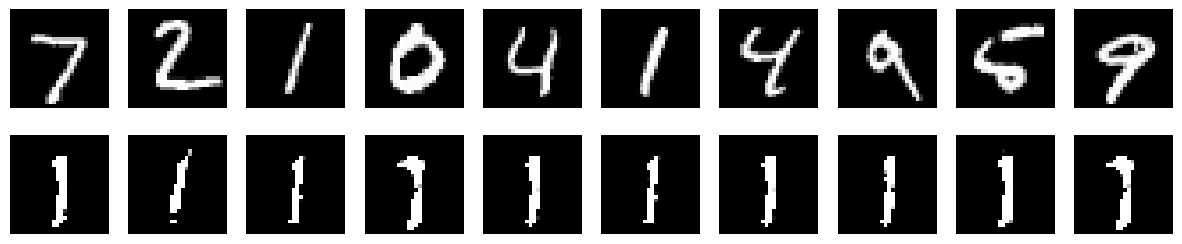

In [23]:
visualize_reconstructions(vae, test_loader)

In [24]:
# 可视化潜在空间（仅适用于latent_dim=2）
def visualize_latent_space(model, loader, device=device):
    if latent_dim != 2:
        print("Latent space visualization requires latent_dim=2")
        return
    
    model.eval()
    z_list = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.view(-1, 784).to(device)
            mu, _ = model.encoder(x)
            z_list.append(mu.cpu().numpy())
            labels.append(y.numpy())
    
    z_list = np.concatenate(z_list)
    labels = np.concatenate(labels)

    # 绘制潜在空间
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_list[:, 0], z_list[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Visualization')
    plt.show()

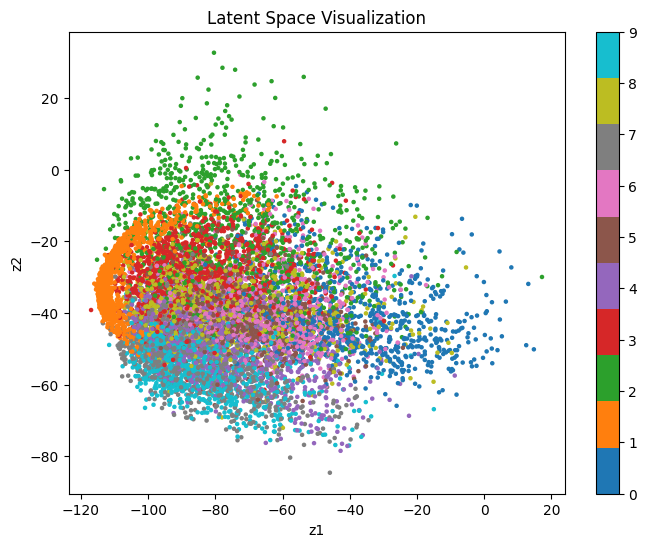

In [25]:
visualize_latent_space(vae, test_loader)